In [1]:
!pip install catboost

  Using cached catboost-1.2.7-cp312-cp312-macosx_11_0_universal2.whl.metadata (1.2 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-macosx_10_13_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached narwhals-1.

In [4]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


# House Hunter: Powered by CatBoost
This project uses the CatBoost machine learning model to predict house prices in the Ames Housing dataset. It demonstrates how gradient boosting can effectively handle structured data with both numerical and categorical features, achieving strong predictive performance with minimal preprocessing.

## Load (install) Libraries
- Ensure you have Sci-Kit Learn & CatBoost libraries installed in your environment. If not, you can install them using the following commands:

- !pip install catboost
- !pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv("/Users/isaiah/Downloads/AmesHousing.csv")  # Ensure the dataset is in your working directory

# Drop rows with missing target
df = df[df['SalePrice'].notnull()]
df.shape


(2579, 85)

## Feature & Target Split
This part requires you to explore the data and identify the necessary columns

In [3]:
X = df.drop(['PID', 'SalePrice'], axis=1)
y = df['SalePrice']

# Identify categorical columns
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Convert all categorical columns to string and handle NaNs BEFORE train-test split
for col in cat_cols:
    X[col] = X[col].astype(str).fillna("nan")

# Now split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=77
)


## Create Pools

### Why Create Pools in CatBoost?

When working with CatBoost, converting your dataset into a **Pool** object is an essential step. Here’s why:

1. **Handling Categorical Features:**
   - The Pool object allows you to specify which columns are categorical (using the `cat_features` parameter). CatBoost then applies its native techniques (such as target statistics and permutation-based encoding) to process these features, eliminating the need for manual one-hot encoding.

2. **Efficient Data Management:**
   - Pools are optimized for memory usage and speed. This means that data access during training is faster, which is especially important when working with larger datasets.

3. **Consistent Data Processing:**
   - Converting your data into a Pool ensures that both your training and validation/test sets are processed in the same manner. This consistency is crucial for accurate model evaluation and avoids discrepancies in how missing values or categorical data are handled.

4. **Seamless Integration with CatBoost Features:**
   - Pools enable CatBoost’s built-in functionalities, such as cross-validation, grid search, and early stopping. This integration makes the model tuning and evaluation process smoother and more efficient.

---

In summary, creating Pools helps leverage CatBoost’s strengths by managing categorical features properly, optimizing data access, ensuring consistent preprocessing, and integrating with advanced tuning methods.


In [4]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, cat_features=cat_cols)


## Train CatBoost Model

In [5]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=77
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 71344.7548329	total: 70ms	remaining: 1m 9s
100:	learn: 18794.7831446	total: 717ms	remaining: 6.38s
200:	learn: 15040.9996350	total: 1.36s	remaining: 5.43s
300:	learn: 12936.7603635	total: 2.04s	remaining: 4.73s
400:	learn: 11591.4753103	total: 2.7s	remaining: 4.04s
500:	learn: 10424.4020806	total: 3.37s	remaining: 3.36s
600:	learn: 9602.1532022	total: 4.04s	remaining: 2.68s
700:	learn: 8890.9086040	total: 4.7s	remaining: 2s
800:	learn: 8277.3666964	total: 5.36s	remaining: 1.33s
900:	learn: 7748.9442375	total: 6.03s	remaining: 662ms
999:	learn: 7339.2705762	total: 6.68s	remaining: 0us


## Evaluate the Model

In [6]:
y_pred = model.predict(test_pool)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 20845.84


## Find Most Important Features
Here you can visualise which features contribute the most to the model

### Why Do We Need Feature Importance?

Feature importance is a key tool in machine learning model evaluation and interpretation. Here's why it's useful:

1. **Understanding the Model:**
   - It helps you understand which features (variables) are contributing the most to the model's predictions. This insight can make the model more transparent and easier to explain.

2. **Model Interpretation:**
   - For stakeholders or decision-makers, knowing which factors drive predictions can build trust in the model. For example, in a house price prediction model, knowing that "Overall Quality" or "Living Area" are important can validate domain knowledge.

3. **Feature Selection:**
   - It assists in identifying irrelevant or redundant features. Removing these features can simplify the model, potentially improving performance and reducing training time.

4. **Data Insights:**
   - Analyzing feature importance can reveal hidden patterns or relationships in your data. It might highlight surprising trends that could lead to further investigation or business insights.

5. **Improving the Model:**
   - By understanding which features are less important, you can focus on improving or engineering the features that matter most, which might further enhance the model’s accuracy and robustness.


In [7]:
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances.head(10))

# Optional: Save model
# model.save_model("catboost_ames_model.cbm")


     Feature Id  Importances
0     GrLivArea    16.624697
1   OverallQual    15.982575
2     ExterQual     6.548239
3   TotalBsmtSF     4.444040
4  Neighborhood     3.994817
5   FireplaceQu     3.872626
6       LotArea     3.638312
7    GarageArea     3.626618
8      1stFlrSF     3.614246
9    BsmtFinSF1     3.361599


## Metric Evaluations
We observe the metrics of our model to determine its accuracy

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 100 - mape
r2 = r2_score(y_test, y_pred)

print(f"Approximate Accuracy: {accuracy:.2f}%")
print(f"R² Score: {r2:.4f}")

Approximate Accuracy: 93.45%
R² Score: 0.9326


## Visualise Accuracy of CatBoost Model

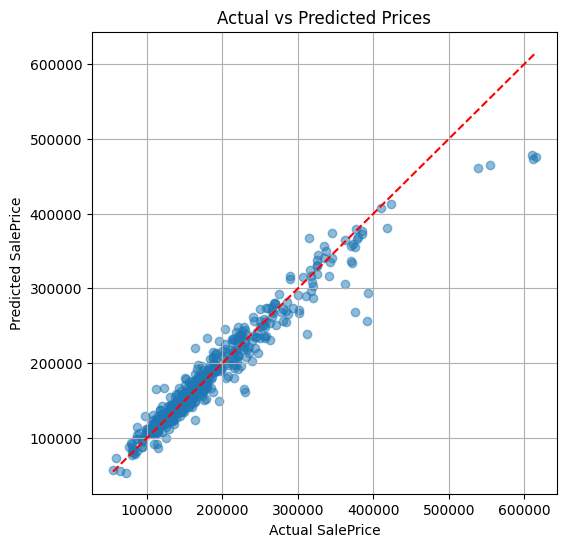

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()
